In [182]:
from datasets import load_dataset, Image
from torchvision.transforms.v2 import Compose, ColorJitter, ToTensor, RandomRotation, RandomPerspective
from torch.utils.data import DataLoader
import evaluate
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor
import torchvision.transforms.functional as F
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer



In [78]:
dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011") #Here I have loaded in a dataset of images of birds

In [80]:
dataset = dataset.cast_column("image", Image(mode="RGB"))

In [81]:
dataset["train"].features #this is the training aspect of the dataset and its features (it's composed of images, labels of bird in image, and a bounding box)

{'image': Image(mode='RGB', decode=True, id=None),
 'label': ClassLabel(names=['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycat

In [117]:
train_dataset = dataset["train"]

In [118]:
labels = dataset['train'].features["label"].names

32 033.Yellow_billed_Cuckoo


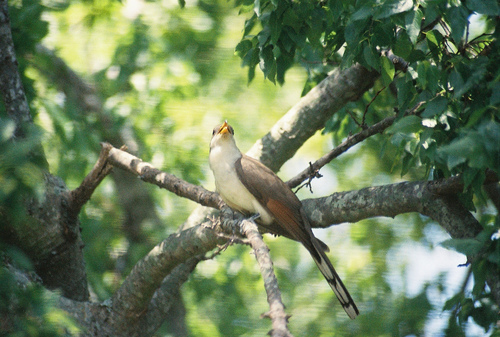

In [119]:
example = dataset["train"][987] #this is a random example of the dataset
print(example['label'], labels[example['label']]) #printing the label number and then the actual label
example['image'] #displaying the image


In [175]:
perspective = Compose([RandomPerspective(distortion_scale=0.5, p=.8), ToTensor()]) 

/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [176]:
train_dataset = dataset["train"]

In [177]:
def transforms(examples):
    examples["pixel_values"] = [perspective(image.convert("RGB")) for image in examples["image"]]
    return examples

In [178]:
train_dataset = train_dataset.with_transform(transforms)


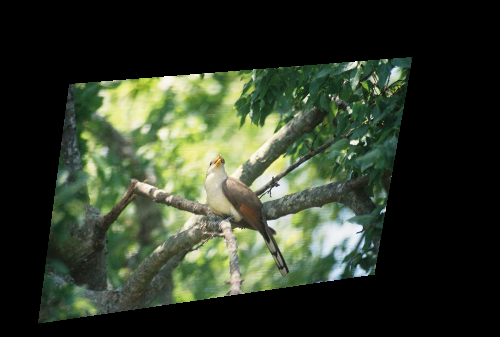

In [179]:
F.to_pil_image(train_dataset[987]['pixel_values']) #this is the image after the jitter transform has been applied

In [180]:
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["labels"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}
dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4)
